In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf

import tensorflow.keras as keras
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.preprocessing as preprocessing

from keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

import os

## Global variables

In [3]:
train_path = 'Intel_Image_Classification/train/'
test_path = 'Intel_Image_Classification/test/'
labels = os.listdir(train_path)
IMG_SIZE = 256

## Functions

In [4]:
def select_random_sample(l):
    n = len(l)
    index = np.random.randint(n)
    return l[index]

In [5]:
def show_image_prediction(dataset, model, classes, rows=4, cols=4):
    fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
    fig.tight_layout()
    for i in range(rows):
        for j in range(cols):
            image = dataset.next()
            image = image.reshape(1, IMG_SIZE, IMG_SIZE, 3)
            predicted_index = model.predict(image).argmax(axis=-1)[0]
            predicted_label = classes[predicted_index]
            image = image.reshape(IMG_SIZE, IMG_SIZE, 3)
            axs[i, j].set_title(predicted_label)
            axs[i, j].imshow(image)
    plt.show()

## Data visualization

In [6]:
def plot_classes(folder_path):
    classes_count =[len(os.listdir(os.path.join(train_path, a))) for a in os.listdir(train_path)]
    classes_count = pd.DataFrame({'label': labels, 'quantity': classes_count})
    fig = px.pie(classes_count, values='quantity', names='label', title='Distribucion de las clases en el dataset')
    fig.show()

In [7]:
plot_classes(train_path)

# Models

In [8]:
train_datagen = preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
)

test_datagen = preprocessing.image.ImageDataGenerator(
    rescale=1/255.0
)


In [9]:
batch_size = 16

train_dataset = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    interpolation='nearest',
    subset='training',
)

valid_dataset = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    interpolation='nearest',
    subset='validation',
)

test_dataset = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    batch_size=1,
    class_mode=None,
    shuffle=False,
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## New model

In [9]:
model_new = Sequential([
    L.Conv2D(32, (3, 3), activation='relu', input_shape = (IMG_SIZE, IMG_SIZE, 3)),
    L.MaxPooling2D(pool_size = (2, 2)), 
    L.Conv2D(64, (3, 3), activation='relu'), 
    L.MaxPooling2D(pool_size = (2, 2)), 
    L.Conv2D(128, (3, 3), activation='relu'), 
    L.MaxPooling2D(pool_size = (2, 2)), 
    L.Flatten(),
    L.Dense(units = 128, activation = 'relu'),
    L.Dense(units = 64, activation = 'relu'), 
    L.Dense(units = 32, activation = 'relu'),
    L.Dense(len(labels), activation='softmax'),
])

checkpoint = ModelCheckpoint('model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

model_new.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
model_new.fit_generator(
    train_dataset,
    validation_data=valid_dataset,
    steps_per_epoch=train_dataset.n//train_dataset.batch_size,
    validation_steps=valid_dataset.n//valid_dataset.batch_size,
    epochs=10,
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
701/701 [==============================] - 554s 790ms/step - loss: 1.0911 - accuracy: 0.5673 - val_loss: 0.8569 - val_accuracy: 0.6746
Epoch 2/10
701/701 [==============================] - 528s 754ms/step - loss: 0.8107 - accuracy: 0.6843 - val_loss: 0.7340 - val_accuracy: 0.7375
Epoch 3/10
701/701 [==============================] - 515s 735ms/step - loss: 0.7016 - accuracy: 0.7388 - val_loss: 0.6805 - val_accuracy: 0.7525
Epoch 4/10
701/701 [==============================] - 515s 734ms/step - loss: 0.6124 - accuracy: 0.7816 - val_loss: 0.5732 - val_accuracy: 0.7925
Epoch 5/10
701/701 [==============================] - 524s 748ms/step - loss: 0.5586 - accuracy: 0.7953 - val_loss: 0.5682 - val_accuracy: 0.7993
Epoch 6/10
701/701 [==============================] - 531s 758ms/step - loss: 0.5175 - accuracy: 0.8146 - val_loss: 0.5035 - val_accuracy: 0.8300
Epoch 7/10
701/701 [============================

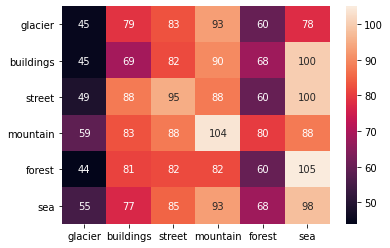

176/176 [==============================] - 52s 294ms/step - loss: 0.5294 - accuracy: 0.8071


[0.5294319987297058, 0.8070613145828247]

In [143]:
sns.heatmap(
    confusion_matrix(
        valid_dataset.classes, 
        model_new.predict(valid_dataset).argmax(axis=-1)
    ),
    annot=True,
    fmt='d',
    xticklabels=labels,
    yticklabels=labels,
)
plt.show()
score = model_new.evaluate(valid_dataset)
score

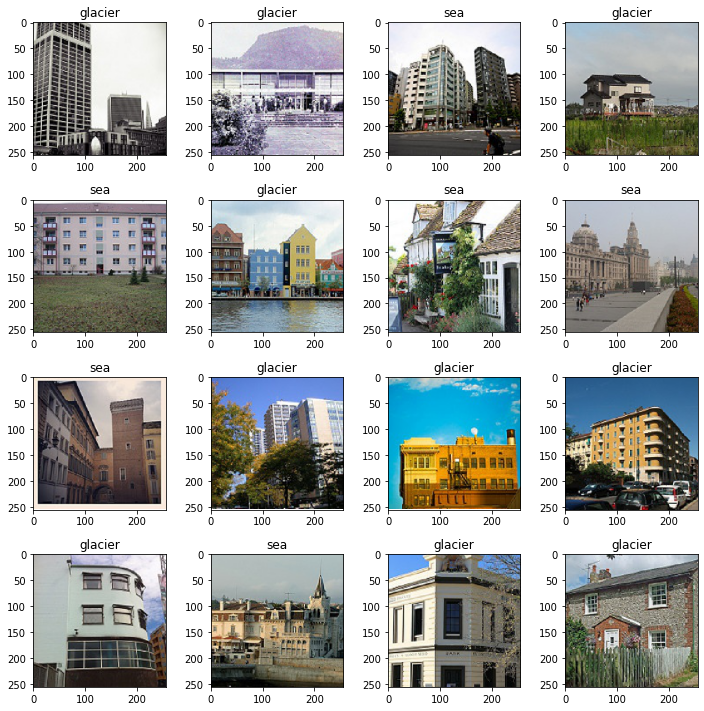

In [161]:
show_image_prediction(test_dataset, model_new, labels)

## Import pretrained model

In [10]:
model_pretrained_resnet50 = keras.applications.ResNet50(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    classes=1000,
)

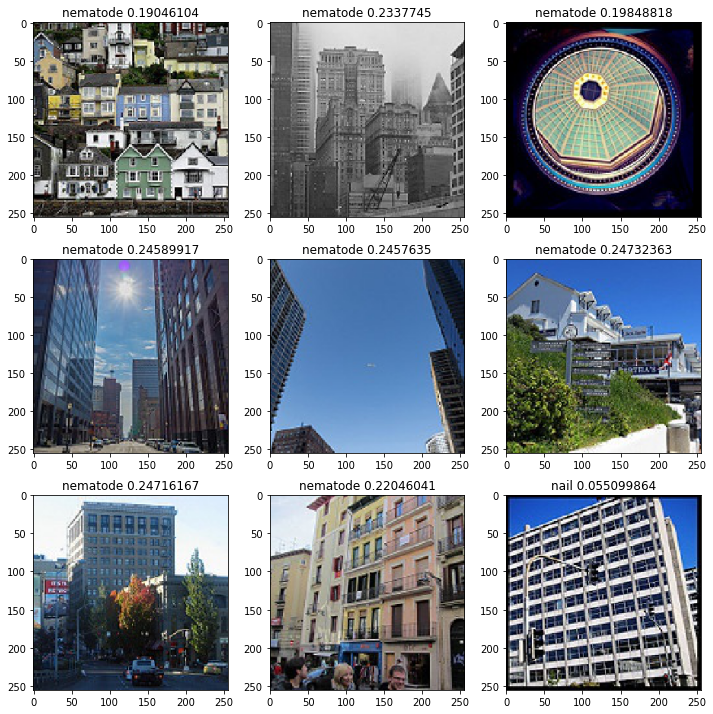

In [23]:
rows=3
cols=3
fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
fig.tight_layout()
for i in range(rows):
    for j in range(cols):
        image = test_dataset.next()
        prediction_index = model_pretrained_resnet50.predict(image)
        prediction_top = decode_predictions(prediction_index, 5)
        axs[i, j].set_title(
            str(prediction_top[0][0][1]) + ' ' + str(prediction_top[0][0][2])
        )
        image = image.reshape(IMG_SIZE, IMG_SIZE, 3)
        axs[i, j].imshow(image)
plt.show()

## Transfer learning

In [10]:
model_pretrained_resnet50_no_top = keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    classes=1000,
)

resnet50_no_top = model_pretrained_resnet50_no_top.output
resnet50_no_top = L.GlobalAveragePooling2D()(resnet50_no_top)
resnet50_no_top = L.Dense(128, activation='relu')(resnet50_no_top)
resnet50_no_top = L.Dense(64, activation='relu')(resnet50_no_top)
output_layer = L.Dense(len(labels), activation='softmax')(resnet50_no_top)

model_transfer_learning = keras.models.Model(
    inputs=model_pretrained_resnet50_no_top.input,
    outputs=output_layer,
)

for layer in model_pretrained_resnet50_no_top.layers:
    layer.trainable = False

checkpoint = ModelCheckpoint(
    'model_resnet50_transfer.h5', 
    save_best_only=True, 
    monitor='val_accuracy', 
    mode='max'
)

model_transfer_learning.compile(
    loss='categorical_crossentropy',
    optimizer='adam', 
    metrics=['accuracy'],
)

In [11]:
history = model_transfer_learning.fit(
    train_dataset,
    validation_data=valid_dataset,
    steps_per_epoch=train_dataset.n//train_dataset.batch_size,
    validation_steps=valid_dataset.n//valid_dataset.batch_size,
    epochs=10,
    callbacks=[checkpoint],
)

Epoch 1/10
701/701 [==============================] - 996s 1s/step - loss: 1.4330 - accuracy: 0.3612 - val_loss: 1.3368 - val_accuracy: 0.4029
Epoch 2/10
701/701 [==============================] - 1031s 1s/step - loss: 1.2499 - accuracy: 0.4593 - val_loss: 1.2015 - val_accuracy: 0.5150
Epoch 3/10
701/701 [==============================] - 906s 1s/step - loss: 1.1732 - accuracy: 0.5020 - val_loss: 1.1114 - val_accuracy: 0.5379
Epoch 4/10
701/701 [==============================] - 1258s 2s/step - loss: 1.1211 - accuracy: 0.5312 - val_loss: 1.1233 - val_accuracy: 0.5368
Epoch 5/10
701/701 [==============================] - 1373s 2s/step - loss: 1.0847 - accuracy: 0.5513 - val_loss: 1.0697 - val_accuracy: 0.5450
Epoch 6/10
701/701 [==============================] - 1226s 2s/step - loss: 1.0490 - accuracy: 0.5698 - val_loss: 1.0184 - val_accuracy: 0.5836
Epoch 7/10
701/701 [==============================] - 1210s 2s/step - loss: 1.0281 - accuracy: 0.5782 - val_loss: 0.9958 - val_accuracy: 0

In [38]:
model_transfer_learning.save('resnet50_transfer_learning.h5')

In [14]:
predictions = model_transfer_learning.predict(valid_dataset)

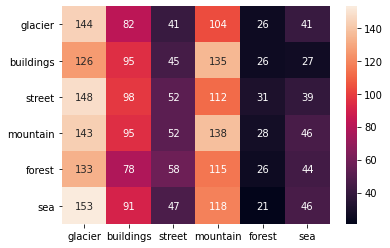

176/176 [==============================] - 238s 1s/step - loss: 1.0488 - accuracy: 0.5649


[1.0487624406814575, 0.5649072527885437]

In [21]:
sns.heatmap(
    confusion_matrix(
        valid_dataset.classes, 
        predictions.argmax(-1),
    ),
    annot=True,
    fmt='d',
    xticklabels=labels,
    yticklabels=labels,
)
plt.show()
score = model_transfer_learning.evaluate(valid_dataset)
score

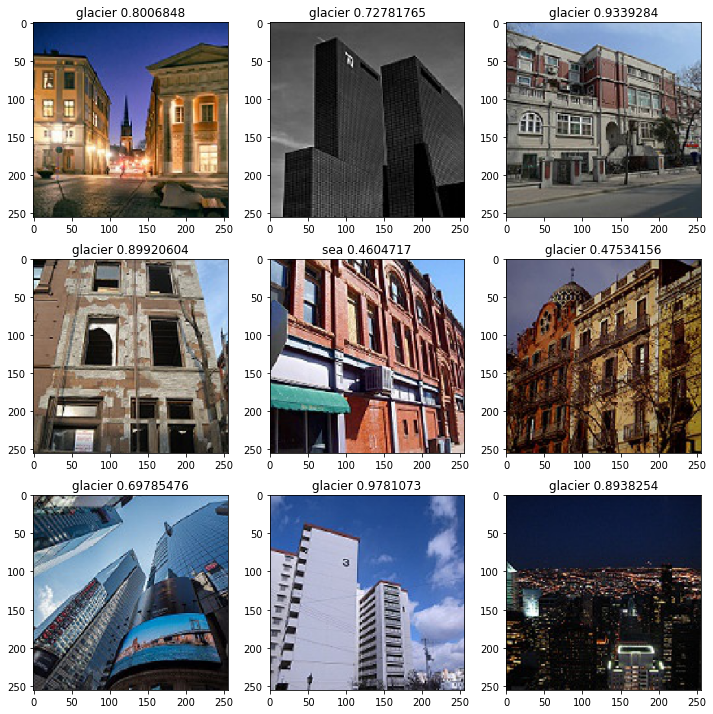

In [46]:
rows=3
cols=3
fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
fig.tight_layout()
for i in range(rows):
    for j in range(cols):
        image = test_dataset.next()
        prediction = model_transfer_learning.predict(image)
        prediction_index = prediction.argmax(axis=-1)[0]
        proba = prediction[0][prediction_index]
        axs[i, j].set_title(
            str(labels[prediction_index]) + ' ' + str(proba)
        )
        image = image.reshape(IMG_SIZE, IMG_SIZE, 3)
        axs[i, j].imshow(image)
plt.show()